In [1]:
import os
import torch
import torchaudio
from matplotlib import pyplot as plt
from IPython.display import Audio, display, clear_output, HTML
import math
import numpy as np
import pandas as pd
import pickle
import time
import shutil
from cepstrum import cepstrum
import glob
import re
import umap
import umap.plot
from pylab import rcParams
from matplotlib.widgets import Slider
import ipywidgets
import cufflinks as cf
cf.set_config_file(sharing='public',theme='ggplot',offline=True)

In [ ]:
pip install cufflinks

In [28]:
class Station:
    
    def __init__(self, name, thrshold):
        self.name = name
        self.thrshold = thrshold
        self.events = []
        
    def set_event(self, event):
        if (event.duration >= self.thrshold):
            self.events.append(event)

class Event:
    
    def __init__(self, name, wav_dir, station):
        self.name = name
        self.station = station
        self.kind = '' # it will be the original wav file name
        self.duration = 0.0
        self.power = 0.0
        self.calculator(name, wav_dir)
    
    def calculator(self, audio, wav_dir):
        self.kind_set(audio)
        self.audio_average_power(wav_dir)
    
    def audio_average_power(self, wav_dir):
         
        main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
        #main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"

        wav_path = os.path.join(main + wav_dir, self.name)
        waveform, sample_rate = torchaudio.load(wav_path)
        num_channels, num_frames = waveform.shape
        
        if waveform.numpy().shape[1] != 0:
            
            ft_wf = np.fft.fft(waveform.numpy())/(math.sqrt(waveform.numpy().shape[1]))
            
            parseval_waveform = np.sum(waveform.numpy()**2)
            parseval_fourier_transform = np.sum(np.abs(ft_wf)**2)
            
            if (np.float32(round(parseval_waveform,1)) == np.float32(round(parseval_fourier_transform,1))):
                
                self.power = parseval_waveform
                
                duration = torch.arange(0, num_frames) / sample_rate
                self.duration = duration.numpy()[-1]
            
    def kind_set(self, audio):
        text = audio.split('_')
        self.kind = text[2]

def folders(wav_dir, station):
    
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    wav_noise_names = os.listdir(wav_dir + noise)
    wav_not_noise_names = os.listdir(wav_dir + not_noise)
    
    print(station.name, " -> In Noise folder")
    
    for w in wav_noise_names:
        station.set_event(Event(w, wav_dir + noise, station.name))
    
    print(station.name, " -> In Not Noise folder")
    
    for nn in wav_not_noise_names:
        station.set_event(Event(nn, wav_dir + not_noise, station.name))
    
    return station

def dataframer(stations):
    
    thrshold = 0.5
    data = []
    framer = []
    
    for s in stations:
        
        data.clear()
        
        for e in s.events:
            
            if e.duration >= thrshold:
                data.append([s.name, e.name, e.kind, e.duration, e.power])
        
        framer.append(pd.DataFrame(data.copy(), columns = ['station', 'audio', 'class', 'duration', 'power']))
    
    return framer

#returns a slice of dataframes!!
def _initiator(thrshold):
    
    stations = []
    fls = []

#     main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
#     wav_dir = '/home/kasparov/Documentos/20190114_vpoblete/20221019_Wasserstein/'
    
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda1/")
    fls.append("split_signals_into_labels_and_noise_20221022_for_ronda2/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda3/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda4/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda5/")
    fls.append("split_signals_into_labels_and_noise_20221022_for_ronda6/")
    
    
    for f in fls:
        stations.append(Station(f.split("_")[8], thrshold))
    
    for s in stations:
        
        for f in fls:
            if(f.split("_")[8] == s.name):
                print("Working in: ", s.name)
                s = folders(f, s)
                break
            
    return stations, fls

def _writer(stations):
    
    filewriter = open("stations/stations.fusa", "wb")
    stations = pickle.dump(stations, filewriter)
    filewriter.close()
    
def _npzwriter(stations):
    
    filewriter = open("stations/npz_stations.fusa", "wb")
    stations = pickle.dump(stations, filewriter)
    filewriter.close()
    
def _reader(file):
    
    filereader = open("stations/" + file, "rb")
    stations = pickle.load(filereader)
    filereader.close()
    
    return stations

def _copier(stations, fls):
    
    main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
    #main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    
    for s in stations:
        counter = 0
        l = len(s.events)
        
        for e in s.events:
            
            clear_output()
            print("In ", s.name, "  Files copied:  ",counter, "/", l)
            for f in fls:
                if(e.station == f.split("_")[8]):
                    counter = counter + 1

                    if("ruido" in e.name):
                        item = main+f+noise+e.name
                        shutil.copy(item, main+"stations/"+noise)
                        break
                    else:
                        item = main+f+not_noise+e.name
                        shutil.copy(item, main+"stations/"+not_noise)
                        break
                        
def _npz_copier(stations, fls):
    
    main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
    #main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    
    counter_noise = 0
    counter_event = 0
    for s in stations:
        counter = 0
        
        l = len(s.events)
        
        for e in s.events:
            
            clear_output()
            print("In ", s.name, "  Files copied:  ",counter, "/", l)
            for f in fls:
                if(e.station == f.split("_")[8]):
                    counter += 1
                    if("ruido" in e.name):
                        item = main+f+noise
                        filename = item+e.name
                        newit = main + "stations/" + noise
                        setattr(e, 'kind', e.name)
                        cep_filename = cepstrum(filename)
                        setattr(e, 'name', 'noise'+str(counter_noise)+'.npz')
                        newfile = newit + getattr(e, 'name')
                        np.savez(newfile, cep_filename)
                        counter_noise += 1
                    
                        break
                        
                    else:
                        item = main+f+not_noise
                        filename = item+e.name
                        newit = main + "stations/" + not_noise
                        setattr(e, 'kind', e.name)
                        cep_filename = cepstrum(filename)
                        setattr(e, 'name', 'event'+str(counter_event)+'.npz')
                        newfile = newit + getattr(e,'name')
                        np.savez(newfile, cep_filename)
                        counter_event += 1
                        break
            
    return stations


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
     (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def big_matrix():
    
    npzfilespath =r"/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/stations/ruido/"   
    os.chdir(npzfilespath)
    npfiles= glob.glob("*.npz")
    npfiles.sort(key=natural_keys)
    all_arrays = []
    #print(npfiles)
    
    for i, npfile in enumerate(npfiles):
        #print(npfile)
        X = np.load(os.path.join(npzfilespath, npfile))
        #print(X)
        #print(len(X['arr_0']))
        all_arrays.append(X['arr_0'])
    
    big_matrix = np.array(all_arrays)
    np.savez('big_matrix_noise',big_matrix)
    print(big_matrix.shape)
    
def categorizer(row):
    
    if (row['station'] == 'ronda1/' or row['station'] == 'ronda2/'):
        
        return 'capta_002'
    
    elif (row['station'] == 'ronda3/' or row['station'] == 'ronda6/'):
        
        return 'capta'
    
    elif (row['station'] == 'ronda4/'):
        
        return 'control_acustico'
    
    elif (row['station'] == 'ronda5/'):
        
        return 'mma'
    
    print('falla')

In [ ]:
start = time.time()

stations, fls = _initiator(0.5)

end = time.time()

print(round(end-start,1))

_writer(stations)

In [ ]:
stations = _reader('stations.fusa')

In [3]:
fls=[]
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda1/")
fls.append("split_signals_into_labels_and_noise_20221022_for_ronda2/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda3/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda4/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda5/")
fls.append("split_signals_into_labels_and_noise_20221022_for_ronda6/")

In [ ]:
stations

In [ ]:
npz_station = _npz_copier(stations, fls)
_npzwriter(npz_station)

In [ ]:
df = dataframer(stations)

In [ ]:
df[0].plot(x='duration', y='power', kind='scatter')	

In [ ]:
df

In [ ]:
os.getcwd()

In [ ]:
cd ..

In [4]:
npz_stations = _reader('npz_stations.fusa')

In [5]:
df_npz = dataframer(npz_stations)

In [ ]:
df_npz

In [ ]:
type(df_npz['station'])

In [ ]:
big_matrix()

In [6]:
n_1 =50
m_1 =0.2

n_2 =40
m_2 =0.2

n_3 =30
m_3 =0.2

n_4 =40
m_4 =0.2

n_5 =50
m_5 =0.2

In [25]:
path_bm = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/stations/matrix/'
noises = np.load(path_bm + 'big_matrix_noise.npz')
X = noises['arr_0']
embedding = umap.UMAP(n_neighbors = 50,
                        min_dist  = 0.8,
                        metric='correlation').fit(X)



In [14]:
X

array([[811415.97806863,  31263.61820209,  19012.70886692, ...,
         11094.72711143,  19012.70886692,  31263.61820209],
       [801806.3690062 ,  25428.12993252,  17290.18345612, ...,
         12669.12213622,  17290.18345612,  25428.12993252],
       [822075.16412004,  36171.65977947,  15745.22519786, ...,
          7283.86617533,  15745.22519786,  36171.65977947],
       ...,
       [331572.25339114,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [820811.38718524,  40109.23630779,  22865.80672897, ...,
         13500.46708225,  22865.80672897,  40109.23630779],
       [834552.4047446 ,  17677.43642642,  11715.38160642, ...,
          8003.85631629,  11715.38160642,  17677.43642642]])

In [29]:
frame = [df_npz[0], df_npz[1], df_npz[2], df_npz[3], df_npz[4], df_npz[5]]
df = pd.concat(frame)
df['station_name'] = df.apply(lambda row: categorizer(row), axis=1)
df.sort_values(by=['audio'])
df

,station,audio,class,duration,power,station_name
0,ronda1/,noise0.npz,1653712794_1653712854_ruido_223.wav,13.647708,0.754834,capta_002
1,ronda1/,noise1.npz,1653789034_1653789094_ruido_417.wav,2.769979,0.419892,capta_002
2,ronda1/,noise2.npz,1653706209_1653706269_ruido_160.wav,27.045750,1.402200,capta_002
3,ronda1/,noise3.npz,1655255968_1655256028_ruido_1248.wav,4.182500,0.074135,capta_002
4,ronda1/,noise4.npz,1655063894_1655063954_ruido_1159.wav,1.474979,0.218602,capta_002
...,...,...,...,...,...,...
1998,ronda6/,event7674.npz,62e39b767a2acbde063ecf57_Multitud_1166.wav,10.960229,153.902313,capta
1999,ronda6/,event7675.npz,62e4c87f7a2acbde063ed7a9_Camion_movimiento_202...,11.274271,101.971397,capta
2000,ronda6/,event7676.npz,62e3d6127a2acbde063ed23a_Camion_1479.wav,29.999979,494.117554,capta
2001,ronda6/,event7677.npz,62e23bd47a2acbde063eca5b_Automovil_movimiento_...,18.013229,24.495485,capta


In [30]:
data = df[df['audio'].str.contains('noise')]
data

,station,audio,class,duration,power,station_name
0,ronda1/,noise0.npz,1653712794_1653712854_ruido_223.wav,13.647708,0.754834,capta_002
1,ronda1/,noise1.npz,1653789034_1653789094_ruido_417.wav,2.769979,0.419892,capta_002
2,ronda1/,noise2.npz,1653706209_1653706269_ruido_160.wav,27.045750,1.402200,capta_002
3,ronda1/,noise3.npz,1655255968_1655256028_ruido_1248.wav,4.182500,0.074135,capta_002
4,ronda1/,noise4.npz,1655063894_1655063954_ruido_1159.wav,1.474979,0.218602,capta_002
...,...,...,...,...,...,...
192,ronda6/,noise1789.npz,62e4bf687a2acbde063ed68c_ruido_1965.wav,12.370438,0.873634,capta
193,ronda6/,noise1790.npz,62e3673c7a2acbde063ecb48_ruido_724.wav,0.794667,0.466743,capta
194,ronda6/,noise1791.npz,62e2175c7a2acbde063ec764_ruido_321.wav,0.582500,0.029089,capta
195,ronda6/,noise1792.npz,62e4b7147a2acbde063ed579_ruido_1864.wav,9.151271,1.930381,capta


In [13]:
embedding

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
     metric='correlation', min_dist=0.2, n_neighbors=30)

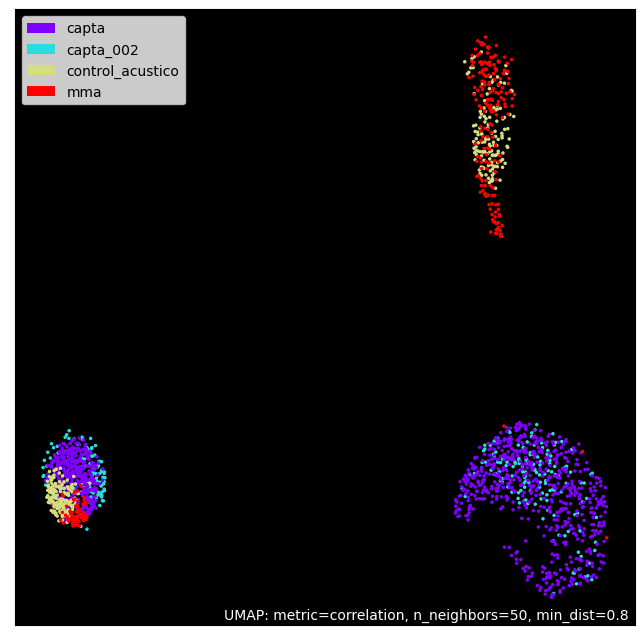

In [31]:
umap.plot.points(embedding, labels = data.station_name,theme='fire')
umap.plot.plt.show()